# Introduction

Imagine how cool it would be if you could see the future. Or, at least, how stock prices develop in the next week. You would be rich very, very fast. But instead of doing all the work for yourself, how about developing a model that does the predictions for us? If we could somehow figure out how to build such a model, we'd never have to worry about money again. So let's do it!


::: {.callout-note}
This notebook is based on [Recurrent Neural Networks (RNNs), Clearly Explained!!!](https://www.youtube.com/watch?v=AsNTP8Kwu80) by StatQuest:

{{< video https://www.youtube.com/embed/AsNTP8Kwu80 >}}
:::


## Stock data

Let's take a look at some imaginary stock courses to get an idea of the data we're working with.

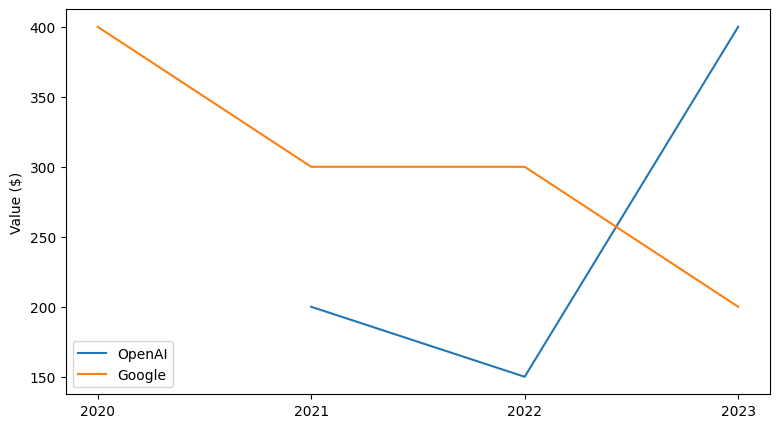

In [1]:
#| label: fig-stock-examples
#| fig-cap: "Examples for stock price changes (values are chosen purely arbitrary)"
#| echo: false

import matplotlib.pyplot as plt

# Plot 1
plt.figure(figsize=(20, 5))  # Set the figure size to be wider
plt.subplot(1, 2, 1)
plt.plot([None, 200, 150, 400], label="OpenAI")
plt.plot([400, 300, 300, 200], label="Google")
plt.ylabel('Value ($)')
plt.legend()
x_labels = ['2020', '2021', '2022', '2023']
plt.xticks(range(len(x_labels)), x_labels)

plt.show()

In this simplified example, we can see the stock of two companies change throughout the years. So how could we use a model to predict these changes?

## Challenges

When we take a closer look at this  kind of data, we can notice a couple of challenges that we have to solve.

### Varying amounts of data {#sec-chall-1}

The amount of data points for each stock can vary. In this example, there are 4 values for Googles, but only 3 values for OpenAIs stock. If you've worked with neural networks before, you know that this problem is not straightforward to solve. Usually, models expect a fixed number of inputs and produce a fixed number of outputs. However, our use case requires the model to work with different amounts of input data!

### Complex courses {#sec-chall-2}

The values of our input data don't necessarily form a straight line. In the example of OpenAI, the value decreases, then increases again. Because of this complexity, we won't get very far with simple statistics like taking the mean or doing linear regression.

So how could we solve these problems?

::: {.callout-note}
Take a moment and just brainstorm a couple of solutions. They don't have to be perfect, but just ask yourself: How could you solve these two problems?
:::

# RNN

Let's see how an RNN can approach these problems and could be used to predict stock prices from our example.

## Setup

First, we'll introduce a couple of example stock data with more or less simple forms to work with:

- Three simple stocks, representing rising, falling and constant values
- A more complicated stock, which falls and rises

In [2]:
stock_rising = [0, 0.5] # expected continuation: 1
stock_constant = [0.5, 0.5] # expected continuation: 0.5
stock_falling = [1, 0.5] # expected continuation: 0
stock_curve = [1, 0.5, 0.5] # expected continuation: 1

::: {.callout-note}
The values in our dataset are normalized to 0 - 1.
:::

Let's visualize the values, so we get a feeling of what's going on.

In [3]:
#| code-fold: true
#| code-summary: Visualization function
import numpy as np
import matplotlib.pyplot as plt

def plot_data(X, Y, title, dotted=True):
    num_plots = len(X)
    max_len = max([len(x) for x in X]) + 1
    fig, axis = plt.subplots(1, num_plots, figsize=(max_len * num_plots, max_len))
    if not isinstance(axis, np.ndarray):
        axis = np.array([axis])

    # Set aspect ratio and y-axis limits for all subplots
    for ax in axis:
        ax.set_aspect('auto', adjustable='box')
        ax.set_ylim(0, 1)
        ax.set_xlim(0, max_len)

    # Input values
    for i, x in enumerate(X):
        space = np.linspace(0, max_len, len(x) + 1)
        axis[i].plot(space, x + [np.nan], label="x")

    # Values to be predicted by the RNN
    for i, y in enumerate(Y):
        # rescale x-axis values
        continuation_point = (len(X[i])-1) / len(X[i]) * max_len
        axis[i].plot([continuation_point, max_len], [X[i][-1], y], linestyle='dotted' if dotted else 'solid', label="y")

    plt.suptitle(title)
    plt.show()

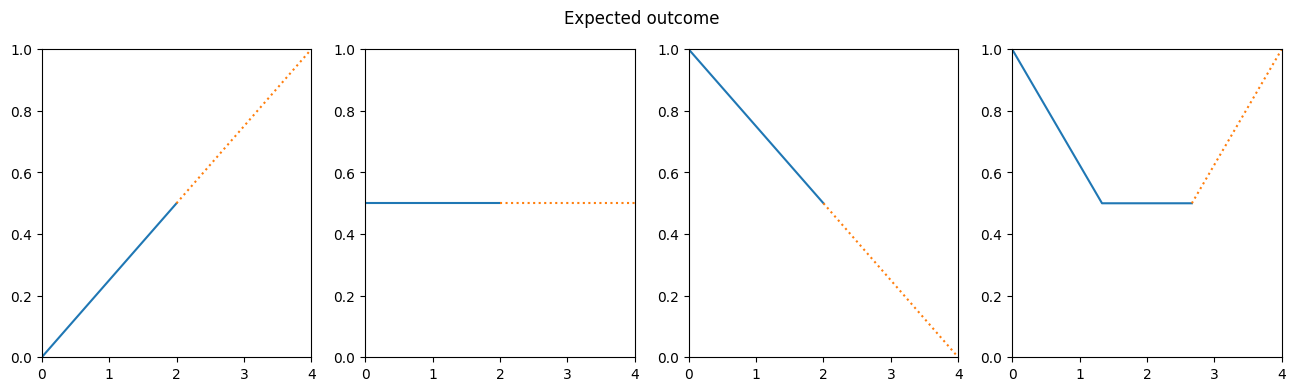

In [4]:
#| label: fig-stock-visualization
#| fig-cap: "Input stock data arrays and the expected continuation"
#| echo: false
plot_data([stock_rising, stock_constant, stock_falling, stock_curve],[1, 0.5, 0,1], "Expected outcome")

## RNN

### Architecture

Given a sequence of input values $x$, predicting an outcome $y$ is not a problem. If you've worked with neural networks before, you've done it a thousand times. You define a sequence of layers and activation functions (to keep it simple we'll use linear layers and relu only), as well as the number of inputs and outputs together with the correct weights, the model will solve the problem. The problem of the stock courses having a complex form^[see @sec-chall-2] can be easily solved with a neural network with enough layers.

![Schema of a feed forward neural network with four inputs and one output](images/feed-forward.png){#fig-ff}

The problem that remains even in a classic feed forward neural network is, that it only works with a fixed number of inputs^[see @sec-chall-1]. To make the model more flexible, RNNs use a "feedback loop", which solves exactly that problem.

Think about how you make a prediction of one of these stock courses. If you're like me, you will read the line from the beginning to the end and build up an overall feeling of the development. In the example of the Google stock, you could think: It starts out at $400, but it's decreasing... and again, it's decreasing - and so on. RNNs do a similar thing, while a normal feed-forward neural network looks at all the data points at the same time and comes to a conclusion all at once.

Imagine a more complex scenario: A stock with 10,000 values over multiple years. A neural network with a fixed input size would look at all the values at once, as if it had 10,000 eyes, and calculate the prediction. Intuitively, an RNN is much more like a human. It looks at each data point sequentially ("feedback loop") and builds up an overall opinion ("hidden state", $h$) of the stock, until it's reached the last data point, at which it will output its prediction.

![Unrolled schema of an RNN that handles four inputs](images/rnn-unrolled.png){#fig-rnn-unrolled}

As you can see, the RNN does the same thing over and over again, until it's looked at all data points. This is why it can be summarized to be more concise, in a recursive version, which gives us the final architecture of an RNN:

![Concise schema of an RNN that handles four inputs. The input values are being passed sequentially, one by one)](images/rnn.png){#fig-rnn-unrolled}

### Implementation

Now that we know how the architecture of an RNN looks like, let's implement it in Python. Essentially, we want to implement the feedback loop, which consists of a linear layer and an activation function, and the output layer, which is another linear layer

In [5]:
def lin(x,w,b=0):
    return x*w+b

def relu(x):
    return max(x,0)

class MiniRnn():
  w1 = 1.4
  w2 = -0.5
  w3 = 1.4
    
  def forward(self, X, i=0, h=0):
    l1 = lin(X[i], self.w1) # <1>
      
    h = relu(l1 + h*self.w2) # <2>
    if(i+1 != len(X)): # <3>
        return self.forward(X, i+1, h)
    
    # Output
    l2 = lin(h, self.w3) # <4>
    return round(l2, 1)

rnn = MiniRnn()

1. Input layer
2. Hidden state & activation function (relu)
3. Feedback loop
4. Output layer

::: {.callout-note}
The weights `w1`, `w2`, `w3` have been calculated using gradient descent. In the next part of this series, we will learn how to do that ourselves - for now we'll just use them as they are.
:::

Let's think about how the model will calculate its prediction. 

1. The RNN iterates over all values in the input sequence (`X`) and starts with no memory ("hidden state") at all because `h=0` in the first iteration.
2. After looking at a new value, it saves all its "thoughts" in the hidden state `h`, until it iterated over all elements.
3.  Once it has looked at all values (and *only* then because this is the only `return` statement that terminates the recursion) the model forms its conclusion and returns the prediction

If you're interested in a more formal definition of the RNN, check out part 2 of this series, where I will introduce some of the math related to RNNs.

::: {.callout-important}
If you've watched the StatQuest video on RNNs, you may notice that relu activation function is being applied *before* its being multiplies with `w2`. If we followed the video, our implementation would be: `h = max(l1 + h, 0) * w2`. However, the implementation from the video is **wrong**, it is not how RNNs are defined.

For now, this is not too important, but we'll see in part 2 why this makes a huge difference.
:::

### Testing

Let's validate the model by looking at the outputs:

In [6]:
r1 = rnn.forward(stock_rising)
r2 = rnn.forward(stock_constant)
r3 = rnn.forward(stock_falling)
r4 = rnn.forward(stock_curve)
r1,r2,r3,r4

(1.0, 0.5, 0.0, 1.0)

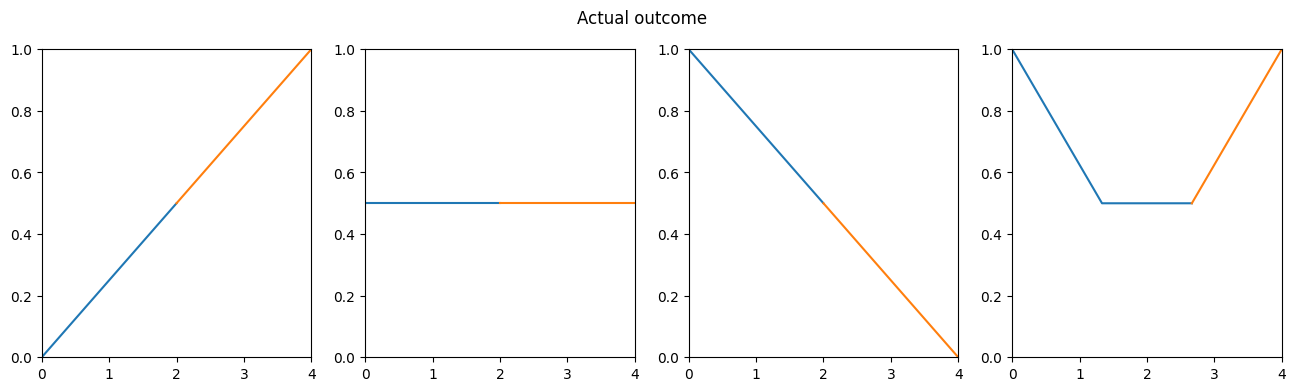

In [7]:
#| label: fig-stock-visualization-prediction
#| fig-cap: "Input stock data arrays with the model prediction"
#| echo: false
plot_data([stock_rising, stock_constant, stock_falling, stock_curve],[r1,r2,r3, r4], "Actual outcome", dotted=False)

The RNN can predict the next values for all the stocks, nice!

To understand each step in detail, here are the steps our RNN took in forward-pass for `stock_falling`.

In [8]:
stock_falling

[1, 0.5]

In [9]:
l1 = relu(1 * 1.4 + 0 * -0.5)
l2 = relu(0.5 * 1.4 + l1 * -0.5)
l3 = 1.4 * l2
print(f"Layers: l1: {l1} l2: {l2} l3: {l3}\nResult: {l3}")

Layers: l1: 1.4 l2: 0.0 l3: 0.0
Result: 0.0


As you can see, each layer uses the output from the previous layer and the same three weights are being shared across all calculations. Even if we passed in a sequence of 100 values, we'd only be using w1,w2 and w3 in the model.

### Validating

Until this point, I only used the examples from the StatQuest video. However, these are not the only values we should try out. What about other forms? It could also be that the model just learned to memorize the four input arrays and maps a single value onto each of them.

To validate if our RNN can actually generalize, let's change the input data. We'll still use values which are normalized to 0 - 1, but we'll change their amplitude.

In [10]:
small_rising = [0,0.1]
small_constant = [0.1,0.1]
small_falling = [1,0.9]
small_curve = [0.2,00.1,0.1]

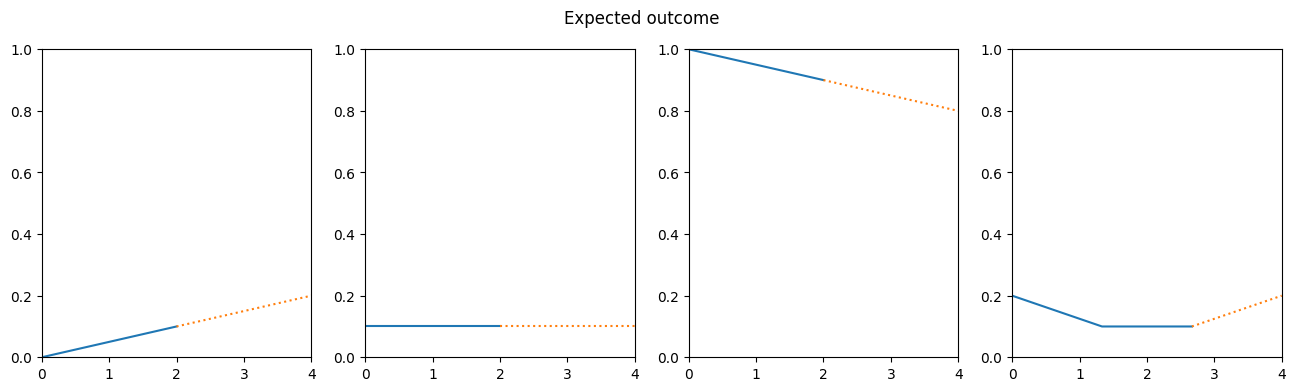

In [18]:
#| label: fig-small-expected
#| fig-cap: "Input validation data arrays with the expected continuation"
#| echo: false
plot_data([small_rising, small_constant, small_falling, small_curve],[0.2,0.1,0.8,0.2], "Expected outcome")

Our validation data still represents the same shapes, but with different values. This should make it harder for a model that just "fakes" the output by remembering the training data. Let's see what our RNN does with it.

In [12]:
s1 = rnn.forward(small_rising)
s2 = rnn.forward(small_constant)
s3 = rnn.forward(small_falling)
s4 = rnn.forward(small_curve)
s1,s2,s3,s4

(0.2, 0.1, 0.8, 0.2)

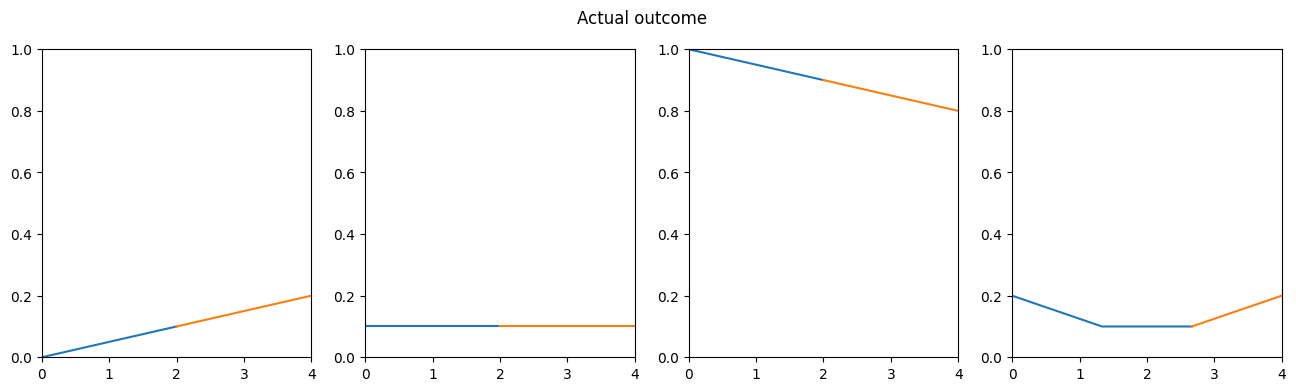

In [13]:
#| label: fig-small-predictions
#| fig-cap: "Input validation data arrays with the model prediction"
#| echo: false
plot_data([small_rising, small_constant, small_falling, small_curve],[s1,s2,s3,s4], "Actual outcome", dotted=False)

The model can correctly predict all of our validation data! This means that it can generalize and find some basic patterns in the data and is not just remembering our training dataset. This is quite an achievement. With these few lines of code, we're able to create a model that can predict any kind of rising / constant / falling sequence of values, without changing any parameter. Imagine how far this approach can go when we scale up the model and increase its complexity!

# Limit testing

In the real world, stock data is a lot more complicated than our training data so far. Let's go a step further and see how the model performs on some crazier input data:

In [14]:
data_zic_zac1 = [0, 1, 0, 1, 0]
data_zic_zac2 = [1, 0, 1, 0, 1]

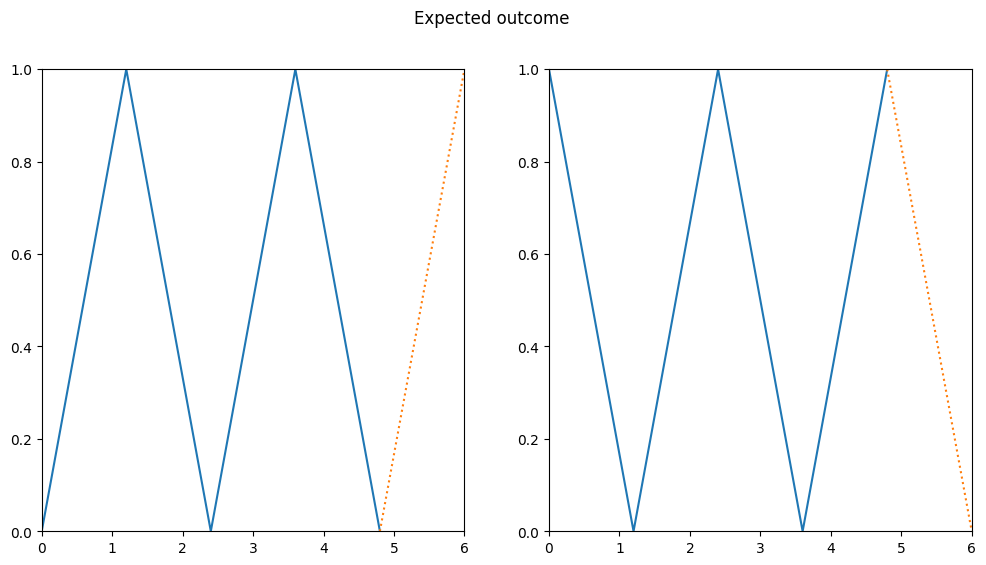

In [15]:
#| label: fig-ziczac-expected
#| fig-cap: "Zic-Zac patterns with the expected continuation"
#| echo: false
plot_data([data_zic_zac1, data_zic_zac2],[1, 0], "Expected outcome")

For a human, this pattern would be straightforward to predict. Let's see what our RNN does with it.

In [16]:
z1 = rnn.forward(data_zic_zac1)
z2 = rnn.forward(data_zic_zac2)
z1, z2

(0.0, 2.0)

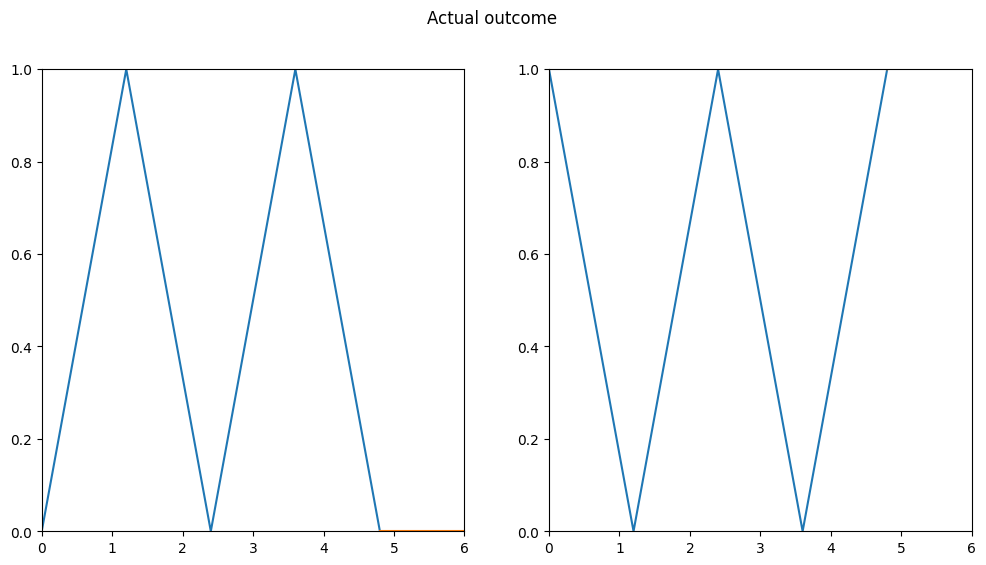

In [17]:
#| label: fig-ziczac-predictions
#| fig-cap: "Zic-Zac patterns with the model prediction"
#| echo: false
plot_data([data_zic_zac1, data_zic_zac2],[z1,z2], "Actual outcome", dotted=False)

It seems like that was too much for our RNN. We can immediately see that something is wrong, the model predicts completely incorrect values. In the second example, they are not even being visualized because the output value is too large to be displayed (maximum is 1).

# Summary

In this article, we took a look at RNNs and what makes them special. They can solve the challenge of handling sequential input data of any size. Moreover, they can predict quite a few patterns with minimal configuration and are very flexible in their use-cases. We took a look at how to implement such a model in Python with pretrained weights and discovered that it works quite well, although it has some limitations.

# Part 2

Until now, we used the same three weights for all of our predictions and simple linear layers to make the predictions. However, we could use backpropagation to train the model to recognize more patterns like the zic-zac, and we could also increase the number of layers, so it can recognize a wider variety of shapes.

But how do we actually find the correct weights with backpropagation to improve our model? Why do the three weights we used so far just magically work? We'll reveal all these mysteries in part 2 of this series...

---

Thank you [Salman](https://github.com/ForBo7) for proof reading and recommending quarto for publishing.